In [1]:
# Imports
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Dynamické zjištění kořenového adresáře projektu
try:
    # Toto funguje, pokud je notebook spuštěn jako soubor (např. ve VS Code z file exploreru)
    # nebo pokud __file__ je definováno
    current_script_path = Path(__file__).resolve()
    # Předpokládáme, že notebook je ve složce 'notebooks', která je přímo v kořeni projektu
    project_root = current_script_path.parent.parent 
except NameError:
    # __file__ není definováno (např. interaktivní spuštění buňky nebo starší Jupyter)
    # Použijeme os.getcwd() a zkontrolujeme, zda jsme ve složce 'notebooks'
    # nebo už v kořeni projektu.
    cwd = Path(os.getcwd())
    if cwd.name == "notebooks" and (cwd.parent / "data").is_dir() and (cwd.parent / "scripts").is_dir():
        project_root = cwd.parent
    elif (cwd / "data").is_dir() and (cwd / "scripts").is_dir():
        project_root = cwd # Vypadá to, že CWD je už kořen projektu
    else:
        # Nouzové řešení, pokud struktura není rozpoznána - může vyžadovat manuální úpravu
        project_root = Path(".").resolve() # Použije aktuální CWD jako kořen
        print(f"Warning: Could not reliably determine project root. Using CWD: {project_root}")
        print("Please ensure this notebook is run from the project's root directory or the 'notebooks' subdirectory.")

print(f"Project root determined as: {project_root}")

# Importy vašich modulů z knihovny subcipher
from subcipher.text_utils import clean_text
from subcipher.stats import transition_matrix # Vaše funkce s debugovacími printy
from subcipher.alphabet import ALPHABET, IDX2CHAR, CHAR2IDX, ALPH_LEN # Přidány všechny potřebné konstanty

print("Subcipher modules imported successfully.")

# --- Definice cest k souborům ---

# Cesta ke korpusu (krakatit.txt)
corpus_file_path = project_root / "data" / "raw" / "corpus" / "krakatit.txt"
print(f"Path to corpus file set to: {corpus_file_path}")

# Cesta pro uložení výsledné referenční matice
# TATO PROMĚNNÁ BUDE POUŽITA PRO UKLÁDÁNÍ A NAČÍTÁNÍ
output_model_path = project_root / "data" / "model" / "reference_tm.npy"
print(f"Path for reference model (load/save) set to: {output_model_path}")

Project root determined as: c:\Git\DeShiftr
Subcipher modules imported successfully.
Path to corpus file set to: c:\Git\DeShiftr\data\raw\corpus\krakatit.txt
Path for reference model (load/save) set to: c:\Git\DeShiftr\data\model\reference_tm.npy


In [2]:
# corpus_file_path je již definováno v předchozí buňce
print(f"\nAttempting to load corpus from: {corpus_file_path}")

raw_text_corpus = None # Inicializace
fallback_corpus_text = "ABECEDA_JE_ZAKLAD_JAZYKA_A_STATISTIKY_POMAHAJI_S_ANALYZOU_TEXTU_"

if not corpus_file_path.exists() or not corpus_file_path.is_file():
    print(f"Corpus file NOT FOUND or is not a file at: {corpus_file_path}")
    raw_text_corpus = fallback_corpus_text
    print(f"Using fallback demo corpus. Length: {len(raw_text_corpus)} characters.")
else:
    try:
        with open(corpus_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            raw_text_corpus = f.read()
        print(f"Successfully loaded corpus from: {corpus_file_path}")
        print(f"Loaded corpus length: {len(raw_text_corpus)} characters.")
    except PermissionError:
        print(f"PermissionError: Could not read the corpus file at {corpus_file_path}. Check file permissions.")
        raw_text_corpus = fallback_corpus_text 
        print(f"Using fallback demo corpus due to permission error. Length: {len(raw_text_corpus)} characters.")
    except Exception as e:
        print(f"An unexpected error occurred while reading {corpus_file_path}: {e}")
        raw_text_corpus = fallback_corpus_text
        print(f"Using fallback demo corpus due to an unexpected error. Length: {len(raw_text_corpus)} characters.")

if raw_text_corpus is None:
    print("Critical error: raw_text_corpus was not set.")


Attempting to load corpus from: c:\Git\DeShiftr\data\raw\corpus\krakatit.txt
Successfully loaded corpus from: c:\Git\DeShiftr\data\raw\corpus\krakatit.txt
Loaded corpus length: 464446 characters.


In [3]:
# Clean the corpus text
# Ujistěte se, že raw_text_corpus je definován z předchozí buňky
if raw_text_corpus:
    cleaned_corpus = clean_text(raw_text_corpus)
    print(f"Cleaned corpus. Length: {len(cleaned_corpus)} characters.")
    # print(f"Cleaned corpus (first 200 chars): {cleaned_corpus[:200]}") # Volitelný výpis
    if not cleaned_corpus:
        raise ValueError("Cleaned corpus is empty. Cannot build model.")
else:
    raise ValueError("raw_text_corpus is not available for cleaning. Check previous cell.")

Cleaned corpus. Length: 439444 characters.


In [4]:
# Build the transition matrix
# Ujistěte se, že cleaned_corpus je definován
if cleaned_corpus:
    # Zde se zavolá vaše funkce transition_matrix s debugovacími printy
    tm_ref = transition_matrix(cleaned_corpus) 
    print(f"\nTransition matrix built. Shape: {tm_ref.shape}")
    print(f"Sum of all elements in matrix (should be close to 1.0): {np.sum(tm_ref):.6f}")
    print(f"Min probability in matrix: {tm_ref.min():.8e}") # Přidáno pro kontrolu
    print(f"Max probability in matrix: {tm_ref.max():.8f}") # Přidáno pro kontrolu
else:
    raise ValueError("cleaned_corpus is not available for building the transition matrix.")


Transition matrix built. Shape: (27, 27)
Sum of all elements in matrix (should be close to 1.0): 1.000000
Min probability in matrix: 2.27474352e-06
Max probability in matrix: 0.03339778


In [5]:
# Inspect the matrix (optional)
# Ujistěte se, že tm_ref je definováno
if 'tm_ref' in locals():
    print("\nSample of the transition matrix (first 5x5 elements):")
    print(tm_ref[:5, :5])

    print("\nMost probable characters following 'A':")
    if 'A' in ALPHABET:
        a_index = ALPHABET.find('A')
        # Ověření, zda a_index je platný a v rozsahu matice
        if a_index != -1 and 0 <= a_index < tm_ref.shape[0]:
            # Získání indexů top 5 pravděpodobností v řádku pro 'A'
            # argsort vrátí indexy od nejmenšího po největší, proto vezmeme posledních 5 a otočíme
            row_a_probabilities = tm_ref[a_index, :]
            top_indices_for_a = np.argsort(row_a_probabilities)[-5:][::-1] 
            
            for idx in top_indices_for_a:
                print(f"  A -> {IDX2CHAR[idx]}: {row_a_probabilities[idx]:.6f}")
        else:
            print(f"Character 'A' not found in ALPHABET or index out of bounds for tm_ref.")
    else:
        print(f"Character 'A' not in ALPHABET constant.")
else:
    print("tm_ref is not defined. Run previous cells.")


Sample of the transition matrix (first 5x5 elements):
[[4.32201269e-05 1.40351675e-03 2.38620596e-03 3.42576375e-03
  4.54948705e-06]
 [1.00998612e-03 2.27474352e-06 3.41211528e-05 2.04726917e-05
  1.91305930e-03]
 [1.07367894e-03 2.27474352e-06 5.45938445e-05 2.27474352e-06
  6.15090649e-03]
 [2.99356248e-03 1.38759355e-04 2.63870249e-04 8.41655103e-05
  5.10224972e-03]
 [4.77696140e-05 1.70378290e-03 3.98762540e-03 4.85657742e-03
  9.09897409e-06]]

Most probable characters following 'A':
  A -> _: 0.026769
  A -> L: 0.009242
  A -> K: 0.005614
  A -> T: 0.005221
  A -> N: 0.004800


In [6]:
# Save the matrix
# Ujistěte se, že tm_ref a output_model_path jsou definovány
if 'tm_ref' in locals() and 'output_model_path' in locals():
    # Vytvoření cílového adresáře, pokud neexistuje
    output_model_path.parent.mkdir(parents=True, exist_ok=True)
    
    np.save(output_model_path, tm_ref)
    print(f"\nReference transition matrix saved to: {output_model_path}")

    # Verify loading
    if output_model_path.exists():
        loaded_tm = np.load(output_model_path)
        if np.array_equal(loaded_tm, tm_ref):
            print("Saved matrix loaded and verified successfully.")
        else:
            print("Error: Loaded matrix does not match the saved matrix!")
    else:
        print(f"Error: Saved matrix file not found at {output_model_path} for verification.")
else:
    print("tm_ref or output_model_path is not defined. Run previous cells.")


Reference transition matrix saved to: c:\Git\DeShiftr\data\model\reference_tm.npy
Saved matrix loaded and verified successfully.


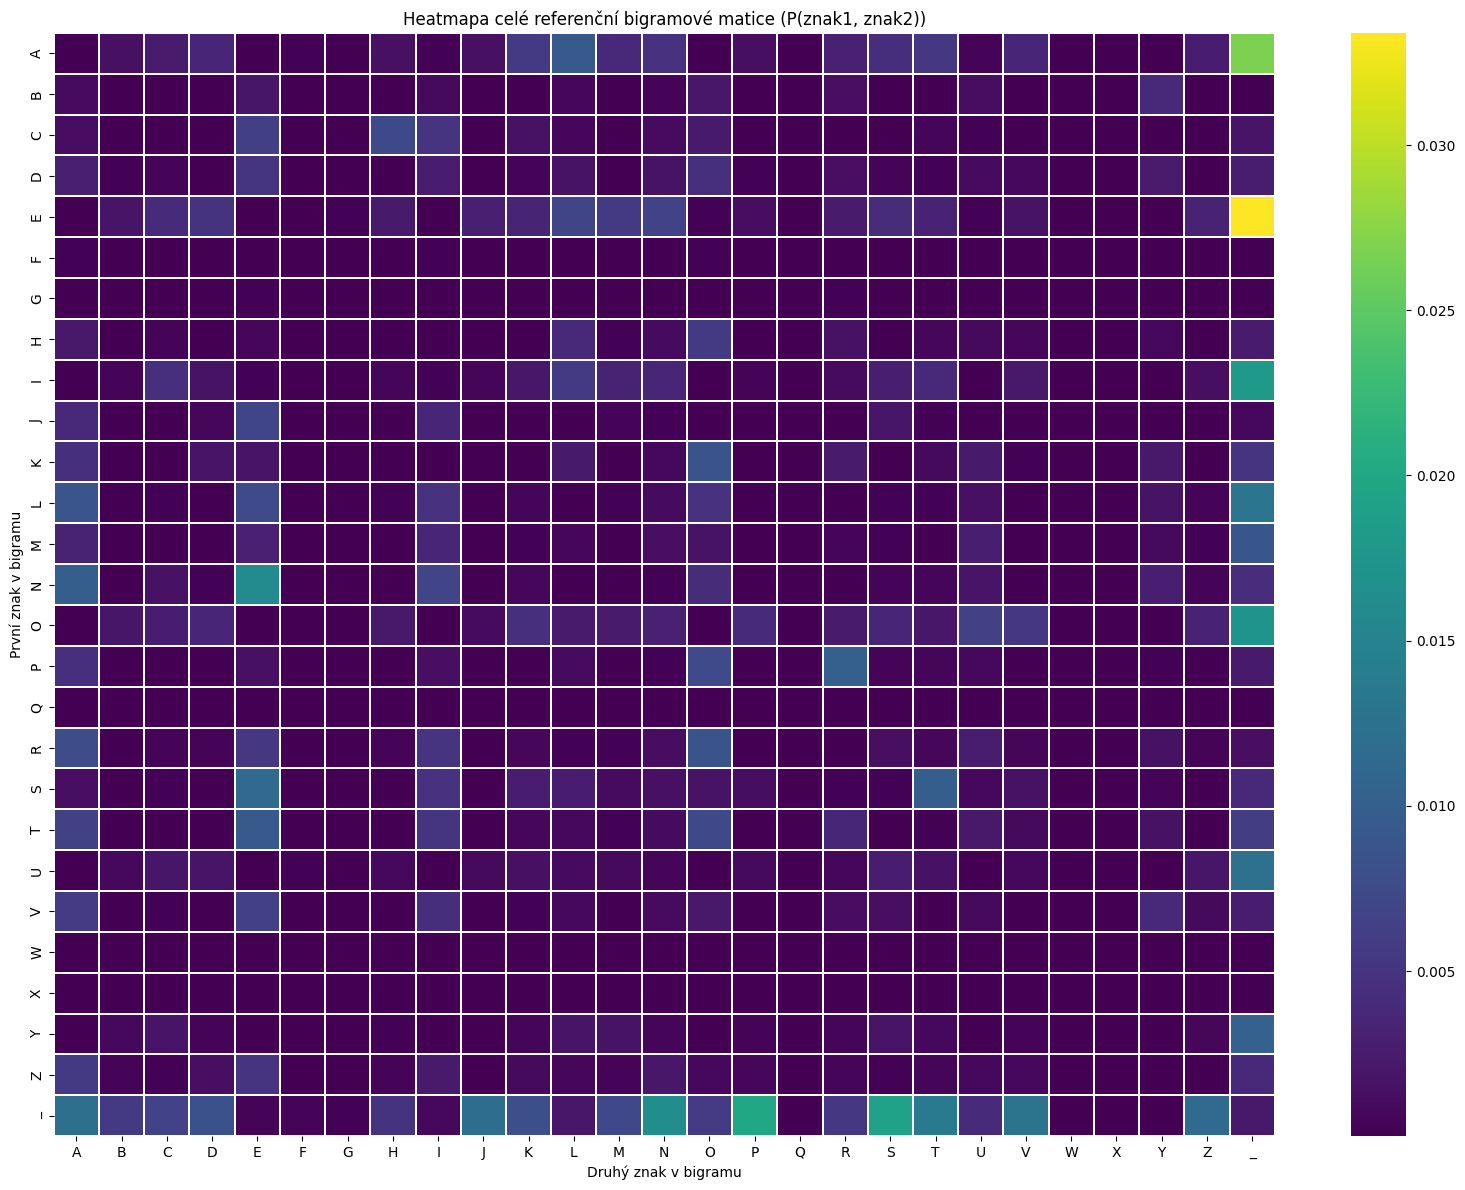

Data range for tm_ref: min=2.27474352e-06, max=0.03339778


In [7]:
# Buňka 7 v 02_bigram_model.ipynb (nebo kde máš vizualizaci)

# Ujistěte se, že tm_ref a ALPHABET jsou definovány z předchozích buněk
if 'tm_ref' in locals() and 'ALPHABET' in locals():
    plt.figure(figsize=(16, 12)) 
    sns.heatmap(
        tm_ref, # Toto by měla být vaše NOVÁ, KVALITNÍ tm_ref
        xticklabels=list(ALPHABET),
        yticklabels=list(ALPHABET),
        cmap="viridis", 
        annot=False, # Pro celou matici 27x27 je False lepší pro přehlednost
        linewidths=.1,
        # Toto dynamické nastavení vmin a vmax je klíčové:
        vmin=tm_ref[tm_ref > 0].min() if tm_ref[tm_ref > 0].size > 0 else 0, 
        vmax=tm_ref.max() # Použije skutečné maximum z vaší matice (mělo by být ~0.033)
    )
    plt.title("Heatmapa celé referenční bigramové matice (P(znak1, znak2))")
    plt.xlabel("Druhý znak v bigramu")
    plt.ylabel("První znak v bigramu")
    plt.tight_layout() 
    plt.show()

    # Přidej si tento print pro ověření rozsahu dat, které heatmapa vizualizuje:
    print(f"Data range for tm_ref: min={tm_ref.min():.8e}, max={tm_ref.max():.8f}")
else:
    print("tm_ref or ALPHABET is not defined. Run previous cells to define them.")